## Modeling the New York Times Covid-19 Data

Implement a simple Bayesian hierarchical model to forecast cases and deaths over the next few days.


In [1]:
import numpy as np
import pandas as pd
import json
import herepy
import plotly.graph_objects as go
import datetime
import dateutil.parser

geocoderApi = herepy.GeocoderApi('VbY-MyI6ZT9U8h-Y5GP5W1YaOzQuvNnL4aSTulNEyEQ')
df_counties = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv", dtype={"fips": str})
df_states = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv", dtype={"fips": str})
df_census = pd.read_csv('data/county_2019_census.csv')
df_geo = pd.read_csv("https://raw.githubusercontent.com/jdlafferty/covid-19/master/geo-counties.csv", dtype={"fips": str})


In [2]:

def compute_lat_lon(df, geocoder):
    county = list(df['county'])
    state = list(df['state'])
    fips = list(df['fips'])
    cases = list(df['cases'])
    deaths = list(df['deaths'])
    lat = list(np.zeros(len(county)))
    lon = list(np.zeros(len(county)))

    num_to_print=20
    for i in range(len(county)):
        if type(fips[i])==str:
            response = geocoder.free_form('%s, %s' % (county[i], state[i]))
            result = response.as_json_string()
            res = eval(result)
            (clat, clon) = (res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],
                      res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude'])
            lat[i] = clat
            lon[i] = clon
            if (i <= num_to_print) | (i % int(len(county)/20) == 0):
                print("%s, %s: cases=%d, deaths=%d, lat=%f, lon=%f" % \
                        (county[i], state[i], cases[i], deaths[i], lat[i], lon[i]))
                if (i>=num_to_print):
                    print("...")            
    return (lat,lon)


def lat_lon_of_address(addr):
    response = geocoderApi.free_form(addr)
    type(response)
    result = response.as_json_string()
    res = eval(result)
    (lat, lon) = (res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],
                  res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude'])
    return (lat, lon)


def county_state_of_address(addr):
    response = geocoderApi.free_form(addr)
    type(response)
    result = response.as_json_string()
    res = eval(result)
    state = res['Response']['View'][0]['Result'][0]['Location']['Address']['AdditionalData'][1]['value']
    county = res['Response']['View'][0]['Result'][0]['Location']['Address']['AdditionalData'][2]['value']
    return (county, state)


In [3]:
def process_recent_data(days_back=7):
    date = [dateutil.parser.parse(d) for d in np.array(df_counties['date'])]
    last_date = max(date)
    most_recent_date = last_date.strftime("%Y-%m-%d")
    most_recent_date_long = last_date.strftime("%A %B %d, %Y")
    print("Most recent data: %s" % most_recent_date_long)    

    days = np.array([(last_date - d).days for d in date])
    df_recent = df_counties[days < days_back]
    df_recent = df_recent.sort_values('cases', ascending=False)
    df_recent = df_recent.reset_index().drop('index',1)
    
    df_recent = pd.merge(df_recent, df_geo)
    df_recent = pd.merge(df_recent, df_census, how='left', on=['county','state'])
    df_recent = df_recent[df_recent['county'] != 'Unknown']
    df_recent['population'] = np.array(df_recent['population'], dtype='int')
    
    cases = np.array(df_recent['cases'])
    population = np.array(df_recent['population'])
    cases_per_100k = np.round(100000*np.array(cases/population),1)
    df_recent['cases_per_100k'] = cases_per_100k
    
    return (df_recent, most_recent_date_long)


In [4]:
df_recent, most_recent_date = process_recent_data(days_back=7)
df_recent.head(30)

Most recent data: Friday April 03, 2020


,date,county,state,fips,cases,deaths,lat,lon,population,cases_per_100k
0,2020-04-03,New York City,New York,NaN,57160,1867,40.71455,-74.00714,8900000,642.2
1,2020-04-02,New York City,New York,NaN,51810,1562,40.71455,-74.00714,8900000,582.1
2,2020-04-01,New York City,New York,NaN,47440,1374,40.71455,-74.00714,8900000,533.0
3,2020-03-31,New York City,New York,NaN,43139,1096,40.71455,-74.00714,8900000,484.7
4,2020-03-30,New York City,New York,NaN,38087,914,40.71455,-74.00714,8900000,427.9
5,2020-03-29,New York City,New York,NaN,33768,776,40.71455,-74.00714,8900000,379.4
6,2020-03-28,New York City,New York,NaN,30766,672,40.71455,-74.00714,8900000,345.7
7,2020-04-03,Westchester,New York,36119,12350,67,41.11909,-73.78870,967506,1276.5
8,2020-04-02,Westchester,New York,36119,11566,67,41.11909,-73.78870,967506,1195.4
9,2020-04-01,Westchester,New York,36119,10683,25,41.11909,-73.78870,967506,1104.2


In [5]:
def compute_deltas(df, days_back=30):
    nd = pd.DataFrame()
    counties = list(df['county'])
    states = list(df['state'])
    state_county = set([sc for sc in zip(states, counties)])
    for (state, county) in state_county:
        this_county = pd.DataFrame(df[(df['county']==county) & (df['state']==state)])
        cp100k = np.array(this_county['cases_per_100k'])
        delta = np.append(np.maximum(-np.diff(cp100k),0), np.nan)
        this_county['delta'] = delta
        nd = nd.append(this_county)

    date = [dateutil.parser.parse(d) for d in np.array(nd['date'])]
    last_date = max(date)
    days = np.array([(last_date - d).days for d in date])
    nd = nd[days < days_back]
    nd = nd.sort_values(['cases', 'state', 'county'], ascending = (False, True, True))
    return nd


In [6]:
df_delta = compute_deltas(df_recent, days_back=3)

In [7]:
df_delta.head(50)

,date,county,state,fips,cases,deaths,lat,lon,population,cases_per_100k,delta
0,2020-04-03,New York City,New York,NaN,57160,1867,40.71455,-74.00714,8900000,642.2,60.1
1,2020-04-02,New York City,New York,NaN,51810,1562,40.71455,-74.00714,8900000,582.1,49.1
2,2020-04-01,New York City,New York,NaN,47440,1374,40.71455,-74.00714,8900000,533.0,48.3
7,2020-04-03,Westchester,New York,36119,12350,67,41.11909,-73.78870,967506,1276.5,81.1
14,2020-04-03,Nassau,New York,36059,12024,138,42.51642,-73.61127,1356924,886.1,105.9
8,2020-04-02,Westchester,New York,36119,11566,67,41.11909,-73.78870,967506,1195.4,91.2
9,2020-04-01,Westchester,New York,36119,10683,25,41.11909,-73.78870,967506,1104.2,74.0
15,2020-04-02,Nassau,New York,36059,10587,95,42.51642,-73.61127,1356924,780.2,76.0
21,2020-04-03,Suffolk,New York,36103,10154,96,40.96009,-72.83434,1476601,687.7,95.4
16,2020-04-01,Nassau,New York,36059,9555,76,42.51642,-73.61127,1356924,704.2,74.5


In [8]:
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline


In [9]:
def prepare_for_simulation(df_delta):
    df = df_delta.drop(['lat','lon', 'fips'], axis=1)
    df_nonzero = df[df['delta'] > 0]
    df = pd.DataFrame(df_nonzero)
    df['z'] = np.log(np.array(df['delta'])/1e5) - np.log(1-np.array(df['delta'])/1e5)
    df['psi'] = df['z']
    df['var'] = 1/(np.array(df['delta'])*(1-np.array(df['delta']/1e5)))
    df['d'] = 1/(1+1/np.array(df['var']))
    return df

,date,county,state,cases,deaths,population,cases_per_100k,delta,z,psi,var,d
0,2020-04-03,New York City,New York,57160,1867,8900000,642.2,60.1,-7.416314,-7.416314,0.016649,0.016376
1,2020-04-02,New York City,New York,51810,1562,8900000,582.1,49.1,-7.618575,-7.618575,0.020377,0.019970
2,2020-04-01,New York City,New York,47440,1374,8900000,533.0,48.3,-7.635011,-7.635011,0.020714,0.020294
7,2020-04-03,Westchester,New York,12350,67,967506,1276.5,81.1,-7.116431,-7.116431,0.012340,0.012190
14,2020-04-03,Nassau,New York,12024,138,1356924,886.1,105.9,-6.849371,-6.849371,0.009453,0.009364
...,...,...,...,...,...,...,...,...,...,...,...,...
10928,2020-04-03,Northampton,Virginia,2,0,11710,17.1,8.6,-9.361077,-9.361077,0.116289,0.104175
9133,2020-04-02,Southampton,Virginia,2,0,17631,11.3,5.6,-9.790103,-9.790103,0.178581,0.151522
10042,2020-04-02,Grays Harbor,Washington,2,0,75061,2.7,1.4,-11.176439,-11.176439,0.714296,0.416670
10155,2020-04-01,Calumet,Wisconsin,2,0,50089,4.0,2.0,-10.819758,-10.819758,0.500010,0.333338


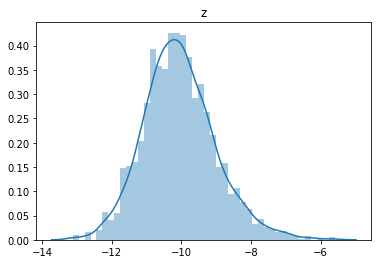

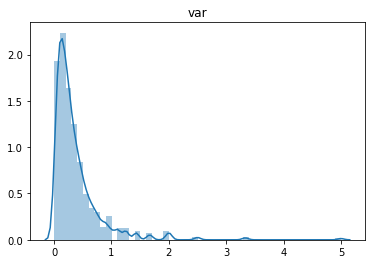

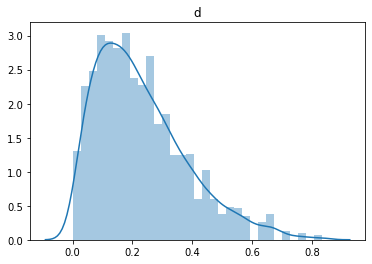

In [10]:
df = prepare_for_simulation(df_delta)
plt.figure()
sbn.distplot(np.array(df['z'])).set_title('z')
plt.figure()
sbn.distplot(np.array(df['var'])).set_title('var')
plt.figure()
sbn.distplot(np.array(df['d'])).set_title('d')
df

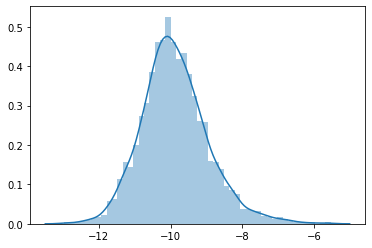

In [11]:
k = df.shape[0]
v = np.sqrt(1/k)
psi = df['psi']
scale = np.sqrt(df['d'])
for b in np.arange(1000):
    b = np.mean(psi)
    mu = np.random.normal(loc=b, scale=v)
    e = df['d']*(mu + df['z']/df['var'])
    psi = np.random.normal(loc=e, scale=scale)
    
sbn.distplot(psi)


In [12]:
delta_hat = 1e5*np.exp(psi)/(1+np.exp(psi))
print(delta_hat)
print(np.array(df['delta']))

[60.05664506 59.87115958 47.88220711 ...  6.3247573   2.93020887
  2.9272258 ]
[60.1 49.1 48.3 ...  1.4  2.   1.4]
